# Work With Standardized Spectral File For ESSP4
Standardized spectra have filenames of the form: `DS#.###_spec_<<inst>>.fits`

For example, the twelfth (012) observation from data set three (3), taken by the HARPS-N instrument will have the file name: `DS3.012_spec_harpsn.fits`

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# Specify file name
# (I'll select a random file from a specified data set)

# Specify where all the data set folders (i.e. DS1) are, here saved into "essp_dir" variable
essp_dir = 

# Specify data set number
dset_num = 1

# Select a file at random from all files in the data set
file_list = glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*.fits'))
file_name = np.random.choice(file_list)

In [3]:
hdus = fits.open(file_name)
hdus.info()

Filename: /Volumes/Hasbrouck/ceph/ESSP_Solar/4_DataSets/Training/DS1/Spectra/DS1.102_spec_harpsn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  WAVELENGTH    1 ImageHDU         8   (4096, 73)   float64   
  2  FLUX          1 ImageHDU         8   (4096, 73)   float32   
  3  UNCERTAINTY    1 ImageHDU         8   (4096, 73)   float32   
  4  CONTINUUM     1 ImageHDU         8   (4096, 73)   float64   
  5  BLAZE         1 ImageHDU         8   (4096, 73)   float32   
  6  COMMON_MASK    1 ImageHDU         8   (4096, 73)   int64   
  7  TELLURIC_MASK    1 ImageHDU         8   (4096, 73)   int64   


In [4]:
# Each data array has shape (number of orders, number of pixels)
num_ord, num_pix = hdus['wavelength'].data.shape

## Continuum Normalized Spectra

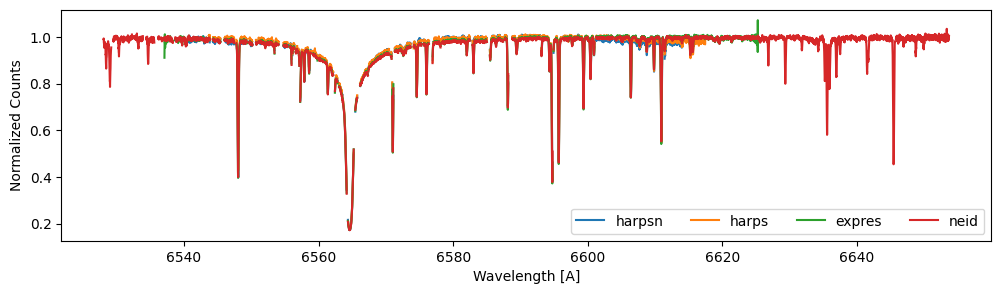

In [5]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,3))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for inst in ['harpsn','harps','expres','neid']:
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    hdus.close()
    
    plt.plot(wave[nord],spec[nord]/cont[nord],label=inst)
    hdus.close()
plt.legend(loc=4,ncol=4)

## Remove Orders With Only NaNs
Here is a simple function for finding which orders have been added and contain only NaNs.  This is demonstrated by employing the resultant mask on an example file from each of the four instruments and printing out the shape of the resultant array with and without the mask.

In [6]:
def getNanMask(flux):
    return np.sum(np.isfinite(hdus['wavelength'].data),axis=1)>0

In [7]:
for inst in ['harpsn','harps','expres','neid']:
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))
    hdus = fits.open(file)
    og_flux = hdus['flux'].data
    flux = og_flux[getNanMask(og_flux)]
    print(inst)
    print('Original Array Shape: ',og_flux.shape)
    print('Masked Array Shape: ',flux.shape)
    print('--------------------------------')
    hdus.close()

harpsn
Original Array Shape:  (73, 4096)
Masked Array Shape:  (69, 4096)
--------------------------------
harps
Original Array Shape:  (73, 4096)
Masked Array Shape:  (71, 4096)
--------------------------------
expres
Original Array Shape:  (87, 7920)
Masked Array Shape:  (85, 7920)
--------------------------------
neid
Original Array Shape:  (93, 9216)
Masked Array Shape:  (93, 9216)
--------------------------------


## Uncertainty
You can use the `blaze` to recover the original counts of each spectrum.  You will also notice that the uncertainty, which is reported slightly differently by each instrument's DRP, is approximately the square root of the original counts of each spectrum.

This Means:
1) For weighting spectral values by photon noise, use the blaze keyword; otherwise use the given uncertainties.
1) When using the uncertainty values in a situation in which absolute value matters, be sure to scale the uncertainties how the spectral values are scaled (e.g., if the spectrum is continuum normalized, also continuum normalize the uncertainties)

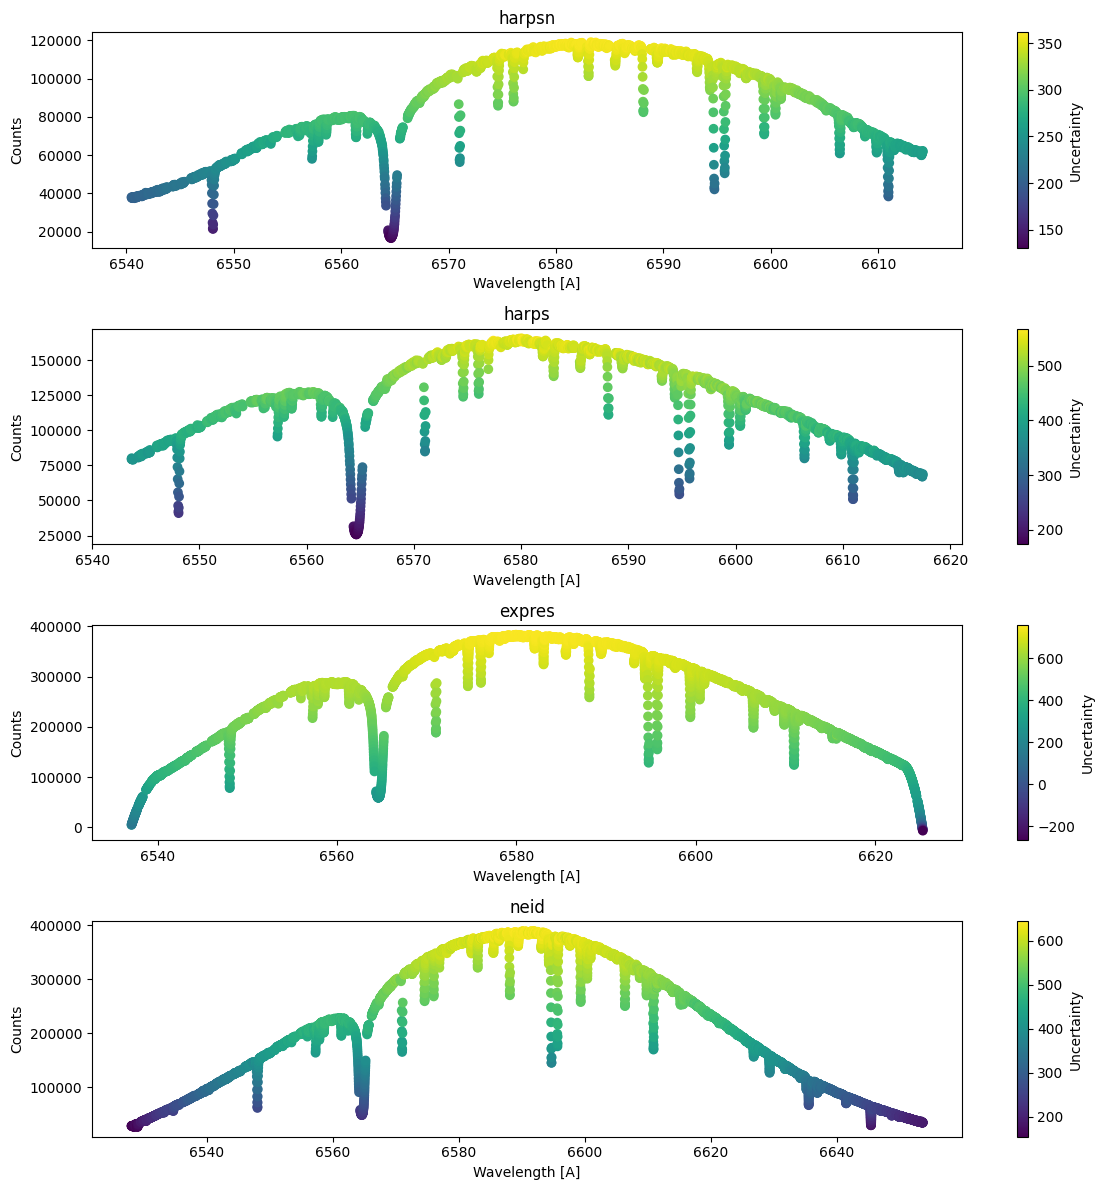

In [8]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

fig, axes = plt.subplots(4,1,figsize=(12,12))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Wavelength [A]')
    ax.set_ylabel('Counts')
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))
    file = np.sort(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))[0]
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    unct = hdus['uncertainty'].data.copy()
    blaz = hdus['blaze'].data.copy()
    hdus.close()
    
    cbar = ax.scatter(wave[nord],spec[nord],c=unct[nord])
    fig.colorbar(cbar,ax=ax,label='Uncertainty')
fig.tight_layout()

## Wavelengths Common to All Four Instruments

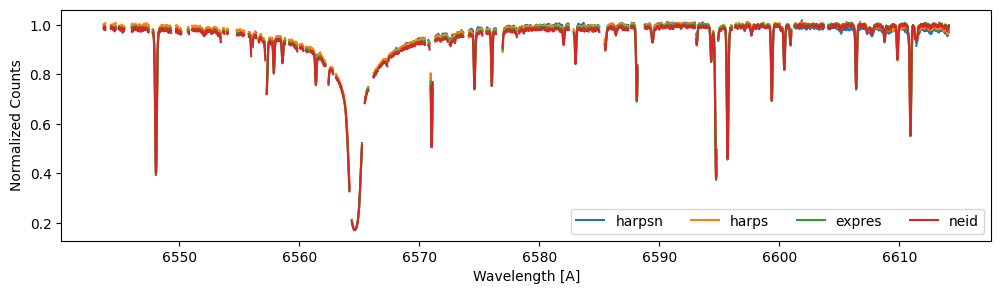

In [9]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,3))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for inst in ['harpsn','harps','expres','neid']:
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    cmask = hdus['common_mask'].data.astype(bool).copy()
    hdus.close()
    
    nord_mask = cmask[nord]
    plt.plot(wave[nord][nord_mask],(spec[nord]/cont[nord])[nord_mask],label=inst)
    hdus.close()
plt.legend(loc=4,ncol=4)

## Telluric Mask
The `telluric_mask` data product is 1 where the spectrum has been masked out becasue of the presence of tellurics.  In other words, wherever `telluric_mask` is 1, the spectrum is a `NaN`.  The below figure demonstrates this.

The inverse of `telluric_mask` can be used to return only values in an order with true values.

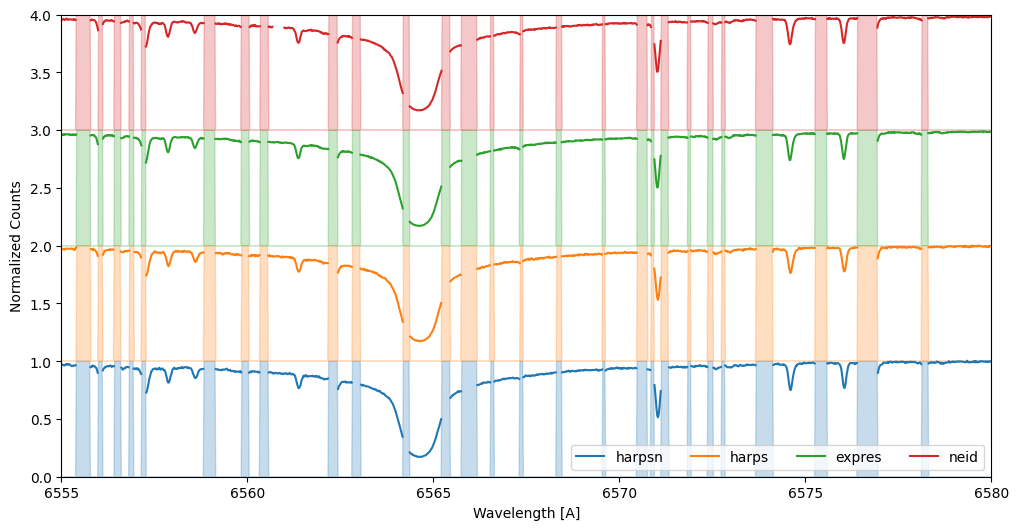

In [10]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,6))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','Spectra',f'DS{dset_num}*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    tmask = hdus['telluric_mask'].data.copy()
    hdus.close()
    
    plt.plot(wave[nord],spec[nord]/cont[nord]+iinst,label=inst)
    plt.fill_between(wave[nord],iinst,iinst+tmask[nord],color=f'C{iinst}',alpha=0.25)
plt.xlim(6555,6580)
plt.ylim(0,4)
plt.legend(loc=4,ncol=4)